# **Fake vs. Real: A Sentiment Analysis and Prediction of Political News**

**Summary**

With data retrieved from **[Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download&select=real.csv)**, a **sentiment - exploratory analysis** and **sentiment/label prediction** based on the **titles** of **political news** was performed. 

As **insights**, a difference between words used in **fake** and **real** titles was found, as a matter of fact the **real** ones seemed to use a more **diplomatic**-like vocabulary while **fake** ones used a more **catchy**, **click-bait** and **unprofessional** - one. Likewise, during this work it was possible to **found** and **visualize** those words that only appeared in **fake** news and **real** news only and so those words that **seemed to occur in both**. These last results are visible in the **Joint visualization** section.

Talking about the **prediction**, a **naive bayes classifier** was developed from scratch based on the **DeepLearning.AI**'s [**Natural Language Processing Specialization**](https://www.coursera.org/specializations/natural-language-processing) resources. By **training** this model, the **classifier** was able to predict the **sentiment/label** of the news with an accuracy of **96%** and **94%** for the **train** and **test** set, respectively.

**Considerations**
- Politics only
- Balanced dataset
- 80:20 train - test split (no validation set was defined during this work)

## **Sentiment Analysis - steps**
1. **Importing and Understanding the Data**
2. **Pre-processing for Word Visualization**
3. **Joint Visualization**
    - Wordclouds only
    - Wordcloud + Venn diagram

## **Prediction - Naive Bayes Classification - steps**
**Note**: The **methodology** and its **explanation** is based on the **DeepLearning.AI**'s [**Natural Language Processing Specialization**](https://www.coursera.org/specializations/natural-language-processing)
1. **Data processing**
2. **Train model**
3. **Predict**
4. **Evaluate: accuracy**
---

## **Importing libraries**

Extra utilities from `nltk` will be needed in order to execute properly.
- `nltk.download('stopwords')`: Needed for NLTK stopwords
- `nltk.download('punkt')`: Needed for `nltk.tokenize.word_tokenize()`

In [7]:
import pandas as pd                                     # Data manipulation
import numpy as np                                      # Numerical python
from collections import defaultdict, Counter            # collections manipulation

import os                                               # OS interaction
from colorama import Fore, Back, Style                  # Command color visualization

import matplotlib.pyplot as plt                         # Visualization
import matplotlib.gridspec as gridspec                  # Grid visualization
import matplotlib.colors as colors                      # Colormap generation
from matplotlib.patches import Patch                    # Util for legend visualization
from matplotlib.lines import Line2D                     # Util for legend visualization
from wordcloud import WordCloud, STOPWORDS              # Text visualization
from matplotlib_venn_wordcloud import venn2_wordcloud   # Venn diagram wordcloud visualization

from nltk.corpus import stopwords                       # Util for identifying stopwords in any language
from nltk import PorterStemmer                          # Gets ths Stem of a word
from nltk.tokenize import word_tokenize                 # Util for tokenizing a string
import string                                           # String utility
import re                                               # Regular expressions, text manipulation

## **Variables & Functions of Interest**
This section contains defined variables that will be of use in during the development of the project.

In [114]:
RANDOM_STATE = 11
HEAD = 5
STR_HEAD = 50
WORDCLOUD_ARGS_RAW = dict(stopwords=STOPWORDS, background_color='white', random_state=RANDOM_STATE)
INTERPOLATION = 'bilinear'
TOP = 100
FIGSIZE = (16,12)

# COLORS, made up with 10-tones in difference from `https://coolors.co/`
FAKE_COLOR_MIN = '#F6A8A2'
FAKE_COLOR_MAX = '#CC2014'
FAKE_COLOR_CMAP = colors.LinearSegmentedColormap.from_list("", [FAKE_COLOR_MIN, FAKE_COLOR_MAX])

REAL_COLOR_MIN = '#70D79E'
REAL_COLOR_MAX = '#1F6F43'
REAL_COLOR_CMAP = colors.LinearSegmentedColormap.from_list("", [REAL_COLOR_MIN, REAL_COLOR_MAX])

BOTH_ONLY_COLOR_MIN = '#73B3E7'
BOTH_ONLY_COLOR_MAX = '#18578C'
BOTH_ONLY_COLOR_CMAP = colors.LinearSegmentedColormap.from_list("", [BOTH_ONLY_COLOR_MIN, BOTH_ONLY_COLOR_MAX])

BOTH_ALL_COLOR_MIN = '#393E41'
BOTH_ALL_COLOR_MAX = '#929BA0'
BOTH_ALL_COLOR_CMAP = colors.LinearSegmentedColormap.from_list("", [BOTH_ALL_COLOR_MIN, BOTH_ALL_COLOR_MAX])

# TEXT
TITLE_SIZE = 20
SUBTITLE_SIZE = 16

PREDICTION_HEADER = f"""
 / \--------------------------------------, 
 \_,|    Fake vs. Real:                   | 
    |    A Prediction of Political News   |
    |                                     |
    |    @system-rowb                     |
    |  ,------------------------------------
    \_/___________________________________/ 
"""

In [63]:
def printf_title(string, fore = Fore.GREEN, style = Style.BRIGHT):
    """
    Function that returns a styled string (with color)

    # Arguments
    string: `str`
        String to be format.
    fore: `Fore.` object
        Fore object to be displayed.
    """
    return f"{fore}{style}{string}:{Style.RESET_ALL} "

## **Importing and Understanding the Data**

In [9]:
# Import the datasets
real_news = pd.read_csv('data/True.csv')
fake_news = pd.read_csv('data/Fake.csv')

In [10]:
# Get basic informattion for the real news
print(real_news.info(), '\n') # Print the news structure/info
print(real_news['subject'].unique(), '\n') # Print the unique subject of real news
real_news.head() # Print the news head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None 

['politicsNews' 'worldnews'] 



,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [11]:
# Get basic information for fake news
print(fake_news.info(), '\n') # Print the structure of the dataset
print(fake_news['subject'].unique(), '\n') # Print the unique subjects of the fake news
fake_news.head() # Print the head of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None 

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east'] 



,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


As we can see, there is a difference of `subject`s between the two datasets. This may affect the results...

In [12]:
# Add a label for identifying whether is a fake or real news
real_news['is_fake'] = 0 # Dummy label for real news
fake_news['is_fake'] = 1 # Dummy label for fake news

# Concatenate the datasets
news = pd.concat([real_news, fake_news]).reset_index().drop(columns='index')

news

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


For the purpose of this analysis, only subjects explicitly labeled as `politics` will be take in account. Thus because 1) it was one easy-identifiable subject found both in the *True* and *Fake* dataset and 2) is thought that considering more categories that are not in both datasets, may bias the results.

In [13]:
politics_subject = ['politicsNews', 'politics'] # Create a list with the politics subjects
pnews = news.query('subject == @politics_subject') # Filter the news dataset by ONLY the 'politics' related subject
print(pnews['subject'].unique(), '\n') # Print the unique values, they MUST be 'politics'-related

# Print the size of the All-news dataset and the politics-only
print(f'All-News records: {news.shape[0]:,}')
print(f'Politics News records: {pnews.shape[0]:,}')
print(f'Politics News records as % All-News records: {pnews.shape[0] / news.shape[0]:.2%}\n')

print(pnews['is_fake'].value_counts()) # Get the distribution of fake and real news

pnews

['politicsNews' 'politics'] 

All-News records: 44,898
Politics News records: 18,113
Politics News records as % All-News records: 40.34%

0    11272
1     6841
Name: is_fake, dtype: int64


,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
37303,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,"Mar 31, 2015",1
37304,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,"Mar 31, 2015",1
37305,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,"Mar 31, 2015",1
37306,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,"Mar 31, 2015",1


## **Pre-processing for Word Visualization**

Before we continue with **train-test split** and **processing** and **classification** of the news. We will **visualize**  via **wordcloud** the words that appear within the **political news' titles**. And see beforehand if we watch up some patterns. First we will need to **separate** the titles into **fake** and **real** ones.

In [14]:
# We will create a string/text with ALL the fake titles from our sample.

# A brief lower-processing to avoid word-duplicates, with just upper cases as differences
fake_titles = " ".join(pnews.query("is_fake == 1").title.str.lower())

# Create a string/text with the concatenation of ALL real news
real_titles = " ".join(pnews.query("is_fake == 0").title.str.lower())

# Show an example of the result
print(f"{Fore.RED}{Style.BRIGHT} FAKE NEWS:{Style.RESET_ALL} {STR_HEAD}-length character example: {Fore.RED}{Style.BRIGHT}{fake_titles[:STR_HEAD]}{Style.RESET_ALL}")
print(f"{Fore.GREEN}{Style.BRIGHT} REAL NEWS:{Style.RESET_ALL} {STR_HEAD}-length character example: {Fore.GREEN}{Style.BRIGHT}{real_titles[:STR_HEAD]}{Style.RESET_ALL}")


 FAKE NEWS: 50-length character example: democrat senator warns mueller not to release find
 REAL NEWS: 50-length character example: as u.s. budget fight looms, republicans flip their


In [15]:
# Define a list of words/tokens for fake and real news, we do this by tokenizing using regular expressions
fake_titles_tokens = Counter(re.findall('\w+', fake_titles))
real_titles_tokens = Counter(re.findall('\w+', real_titles))
both_titles_tokens = Counter(re.findall('\w+', fake_titles + real_titles)) # Get the comnbinations of fake and real tokens, into a single joint counter

# Show an example of the result
print(f"{Fore.RED}{Style.BRIGHT} FAKE NEWS:{Style.RESET_ALL} {HEAD}-most common tokens: {Fore.RED}{Style.BRIGHT}{fake_titles_tokens.most_common(HEAD)}{Style.RESET_ALL}")
print(f"{Fore.GREEN}{Style.BRIGHT} REAL NEWS: {Style.RESET_ALL}{HEAD}-most common tokens: {Fore.GREEN}{Style.BRIGHT}{real_titles_tokens.most_common(HEAD)}{Style.RESET_ALL}")
print(f"{Fore.CYAN}{Style.BRIGHT} BOTH NEWS:{Style.RESET_ALL} {HEAD}-most common tokens: {Fore.CYAN}{Style.BRIGHT}{both_titles_tokens.most_common(HEAD)}{Style.RESET_ALL}")

 FAKE NEWS: 5-most common tokens: [('video', 3355), ('to', 3011), ('s', 2435), ('trump', 2367), ('the', 1858)]
 REAL NEWS: 5-most common tokens: [('trump', 5009), ('s', 4736), ('to', 4238), ('u', 3136), ('on', 2000)]
 BOTH NEWS: 5-most common tokens: [('trump', 7376), ('to', 7249), ('s', 7171), ('in', 3433), ('video', 3374)]


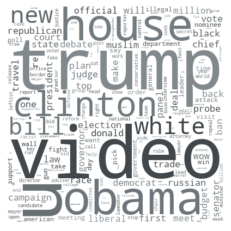

In [16]:
# Generate the wordcloud with the ´both_titles_tokens´. This includes words coming
# BOTH from fake and real news
both_all_titles_wc = WordCloud(**WORDCLOUD_ARGS_RAW, colormap=BOTH_ALL_COLOR_CMAP, width=400, height=400).generate(" ".join(item[0] for item in both_titles_tokens.most_common()))
# Show the both titles wordcloud
plt.imshow(both_all_titles_wc, interpolation = 'bilinear')
_ =  plt.axis('off') # Turn off the axis (the x-y labels around and the frame)

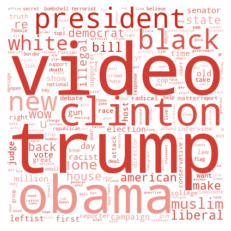

In [17]:
# Generate the wordcloud with the `fake_titles`` text
fake_titles_wc = WordCloud(**WORDCLOUD_ARGS_RAW, colormap=FAKE_COLOR_CMAP, width=400, height=400).generate(" ".join(item[0] for item in fake_titles_tokens.most_common()))
# Show the fake titles wordcloud
plt.imshow(fake_titles_wc, interpolation='bilinear')
_ = plt.axis('off')

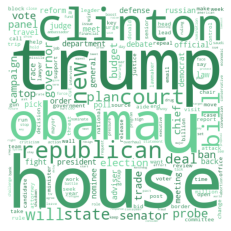

In [18]:
# Create the wordcloud with real titles
real_titles_wc = WordCloud(**WORDCLOUD_ARGS_RAW, colormap=REAL_COLOR_CMAP, height=400, width=400).generate(" ".join(item[0] for item in real_titles_tokens.most_common()))
# Show the wordcloud
plt.imshow(real_titles_wc)
_ = plt.axis('off')

So far, there are **few** major differences between the **fake** and **real** titles. One example may be the word **video** that visualizes as **more frequent** in the **fake news wordcloud** while in the **real news worcloud** is not visible at all.

As contrary, words that appear in both wordclouds are easily identifiable, particulaly, the words **trump**, **clinton** and **obama** appear as the most frequent tokens/word. This may be an issue at the moment of **prediction** because these words may be as equally probable to be **real** or **fake**, affecting the **naive bayes classification algorithm**. Thus, as a **recommendation** they should be taken **political STOPWORDS** for improving accuracy. *(For this work, this last will just be taken as a recommendation and won't be applied)*

Now, which are the **words** that **ONLY** appear within the **fake** and **real** vocabulary? Let's check it out.

Starting with **fake news only**.

In [19]:
# Get the words that ONLY appear in the `fake_titles` set and NOT in `real_titles` set.
# Going inside out, we first get the set difference between the fake and real titles tokens, in other words, only those tokens that are within
# the `fake_titles_tokens` but not in `real_titles_tokens`. Then, we create a new `Counter` with the token and its frequency from the previous set difference.
fake_titles_only = Counter({token:fake_titles_tokens[token] for token in set(fake_titles_tokens).difference(set(real_titles_tokens))})
fake_titles_only.most_common(HEAD)

[('wow', 199),
 ('leftist', 106),
 ('lol', 105),
 ('supporter', 91),
 ('hilarious', 81)]

Now, let's visualize these results. It is important to remark 2 things:
1. The greater the **frequency of the word**, the **biggger** it will be visualized within the wordcloud.
2. For the "one-topic-only" words, their wordclouds will be displayed as a square. This will be necessary for visualization in next steps.

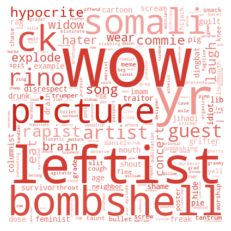

In [20]:
# Visualize a wordcloud with `fake_titles_only`
# What we do here is generate a wordcloud, in the `generate` arguments we set a sorted list from most common tokens to the least and we concatenate all the
# tokens with a space " ", so we can use it in a wordcloud.
fake_titles_only_wc = WordCloud(**WORDCLOUD_ARGS_RAW, colormap=FAKE_COLOR_CMAP, height=400, width=400).generate(" ".join([item[0] for item in fake_titles_only.most_common()]))
plt.imshow(fake_titles_only_wc, interpolation='bilinear')
_ = plt.axis("off")

So far, we can identify three words that highlight **wow**, **leftist** and not so clear **yr**. The first two may be two **catchy words** that may attract the readers. Also we can see that there are words that **are not really, formals-news related** and that may be are way off a **respected** or **serious** news org language, such as **hater, commie, freak, pig, idiot...**.

Replicate the previous procedure, now with **real news only**.

In [21]:
# Get the words that only appear within the `real_titles_tokens` set and are different from the fake ones.
real_titles_only =  Counter({token:real_titles_tokens[token] for token in set(real_titles_tokens).difference(set(fake_titles_tokens))})
real_titles_only.most_common(HEAD)

[('factbox', 314), ('seek', 112), ('mnuchin', 57), ('urge', 55), ('envoy', 54)]

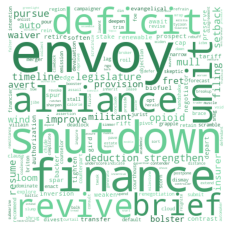

In [22]:
# Visualize `real_titles_only` with a wordcloud
real_titles_only_wc = WordCloud(**WORDCLOUD_ARGS_RAW, colormap=REAL_COLOR_CMAP, height=400, width=400).generate(" ".join([item[0] for item in real_titles_only.most_common()]))
plt.imshow(real_titles_only_wc,)
_ = plt.axis("off")

Now, which are the **"neutral"** words that appear both in **fake** and **real** news?

In [23]:
# First, find the intersection between the `fake_titles_tokens` and `real_titles_tokens` sets. Then, create a new dictionary
# with the token as key, and the sum of the frequency in the `fake_titles_tokens[token]` and `real_titles_tokens[token]`, so
# you get the joint frequency. Finally convert it into a `Counter`
both_titles_only = Counter({token:fake_titles_tokens[token] + real_titles_tokens[token] 
                       for token in set(fake_titles_tokens).intersection(set(real_titles_tokens))})
both_titles_only.most_common(HEAD)

[('trump', 7376), ('to', 7249), ('s', 7171), ('in', 3433), ('video', 3374)]

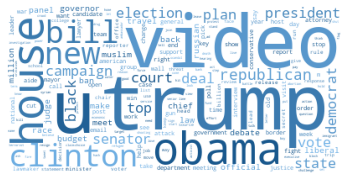

In [24]:
# Create a wordcloud with `both_titles`|
both_titles_only_wc = WordCloud(**WORDCLOUD_ARGS_RAW, colormap=BOTH_ONLY_COLOR_CMAP).generate(" ".join(item[0] for item in both_titles_only.most_common()))
plt.imshow(both_titles_only_wc)
_ = plt.axis("off")

To create a **visually appealing** **wordcloud - venn diagram**, we will get the top 100 words for each one of the sets **REAL**, **BOTH (INTERSECTION)**, and **FAKE** ones. Then we will calculate its set-probability to visualize the relation that each words has within its sets. This is mainly done because some words in the intersection have **considerably greater frequencies** than other sets, causing that words are visualized in a too small (nonvisible) size.

In [25]:
# For each one of the different title sets, get is relative probability
real_titles_only_top_prob = {
    token:freq / np.array([item[1] for item in real_titles_only.most_common(TOP)]).sum()
    for token, freq in real_titles_only.most_common(TOP)}

fake_titles_only_top_prob = {
    token:freq / np.array([item[1] for item in fake_titles_only.most_common(TOP)]).sum()
    for token, freq in fake_titles_only.most_common(TOP)}

both_titles_only_top_prob = {
    token:freq / np.array([item[1] for item in both_titles_only.most_common(TOP)]).sum()
    for token, freq in both_titles_only.most_common(TOP)}

# Create a new dictionary that merges the previous one, into a single set-relative probability
titles_relative_set_prob = (real_titles_only_top_prob | fake_titles_only_top_prob | both_titles_only_top_prob)

For the `venn2_wordcloud` function, as first argument we will use a list of two sets. Each set is the **unique topic** (e.g. real news) + the `both_titles_only_top_prob` set. We do this because the function takes the two sets and looks into the **intersection** between them. As we already **defined the intersection by a given top**, we will just append it to the **unique topic**, so we can get our **intersection** visualized.

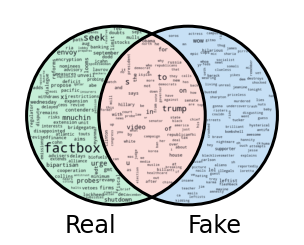

In [26]:
# Create a venn diagram with probability-relation
v = venn2_wordcloud(
    [real_titles_only_top_prob.keys() | both_titles_only_top_prob.keys(), fake_titles_only_top_prob.keys() | both_titles_only_top_prob.keys()],
    set_labels=['Real', 'Fake'], word_to_frequency = titles_relative_set_prob)

# add color
v.get_patch_by_id('10').set_color(REAL_COLOR_MIN)
v.get_patch_by_id('11').set_color(FAKE_COLOR_MIN)
v.get_patch_by_id('01').set_color(BOTH_ONLY_COLOR_MIN)

Not as visually appealing as expected, instead of the relative probability, we will use the **relative rank**. In other words, we will assign a **descending (MOST)** value for visualization. We will also exclude **STOPWORDS** from the sets.

In [27]:
# For each one of the different title sets, get ONLY the ´TOP´ most common words and
# rank them, starting from 1 the least frequent of to ´TOP´ - the most frequent.
# Important note: Exclude those words that are considered STOPWORDS for the ranking.
real_titles_only_top_rank = {item[0]:rank for rank, item 
                             in enumerate(sorted(Counter({token:freq for token, freq in real_titles_only.items() if token not in STOPWORDS}).most_common(TOP),
                             key=lambda item: item[1]))}

fake_titles_only_top_rank = {item[0]:rank for rank, item 
                             in enumerate(sorted(Counter({token:freq for token, freq in fake_titles_only.items() if token not in STOPWORDS}).most_common(TOP), 
                                                 key=lambda item: item[1]))}
both_titles_only_top_rank = {item[0]:rank for rank, item 
                             in enumerate(sorted(Counter({token:freq for token, freq in both_titles_only.items() if token not in STOPWORDS}).most_common(TOP),
                                                 key=lambda item: item[1]))}

# Print an example of what is done
print(real_titles_only_top_rank)

# Merge the previous dicitonaries into a single one
titles_relative_set_rank = (real_titles_only_top_rank | fake_titles_only_top_rank | both_titles_only_top_rank)

{'opioid': 0, 'yellen': 1, 'antitrust': 2, 'duterte': 3, 'backers': 4, 'prepares': 5, 'citing': 6, 'timeline': 7, 'december': 8, 'qatar': 9, 'insurers': 10, 'brief': 11, 'pension': 12, 'lobby': 13, 'subsidies': 14, 'expands': 15, 'nears': 16, 'legislature': 17, 'halts': 18, 'reserve': 19, 'modi': 20, 'biofuels': 21, 'alliance': 22, 'touts': 23, 'ceos': 24, 'risks': 25, 'revive': 26, 'withdraws': 27, 'spokeswoman': 28, 'interests': 29, 'advisory': 30, 'probing': 31, 'delayed': 32, 'extends': 33, 'atlantic': 34, 'emissions': 35, 'aug': 36, 'unit': 37, 'mulls': 38, 'doubts': 39, 'encryption': 40, 'extension': 41, 'myanmar': 42, 'minimum': 43, 'icahn': 44, 'stocks': 45, 'remains': 46, 'regulator': 47, 'measures': 48, 'dec': 49, 'dialogue': 50, 'disappointed': 51, 'revamp': 52, 'path': 53, 'collins': 54, 'expansion': 55, 'sept': 56, 'adds': 57, 'ria': 58, 'vetoes': 59, 'lavrov': 60, 'lockheed': 61, 'abe': 62, 'restrictions': 63, 'nominees': 64, 'cohn': 65, 'cooperation': 66, 'delays': 67, '

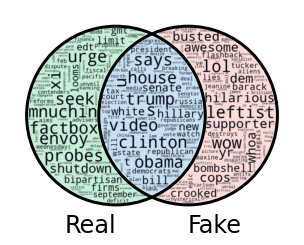

In [28]:
# Generate a wordcloud venn diagram base on the words/tokens rank
v = venn2_wordcloud(
    [real_titles_only_top_rank.keys() | both_titles_only_top_rank.keys(), fake_titles_only_top_rank.keys() | both_titles_only_top_rank.keys()],
    set_labels=['Real','Fake'], word_to_frequency=titles_relative_set_rank
    
)

# Add colors
v.get_patch_by_id('10').set_color(REAL_COLOR_MIN) # REAL NEWS - LEFT SIDE
v.get_patch_by_id('11').set_color(BOTH_ONLY_COLOR_MIN) # BOTH NEWS (REAL & FAKE) - MIDDLE SIDE
v.get_patch_by_id('01').set_color(FAKE_COLOR_MIN) # FAKE NEWS - RIGHT SIDE

# Visualize the diagram
v

## **Joint visualization**

Now, **join** the different **wordclouds** into a single image. To do this, we will generate a $2\times4$ row-column in order to include all 5 wordclouds, we will use `matplotlib.gridspec.GridSpec` to achieve this.

### **Wordclouds only**

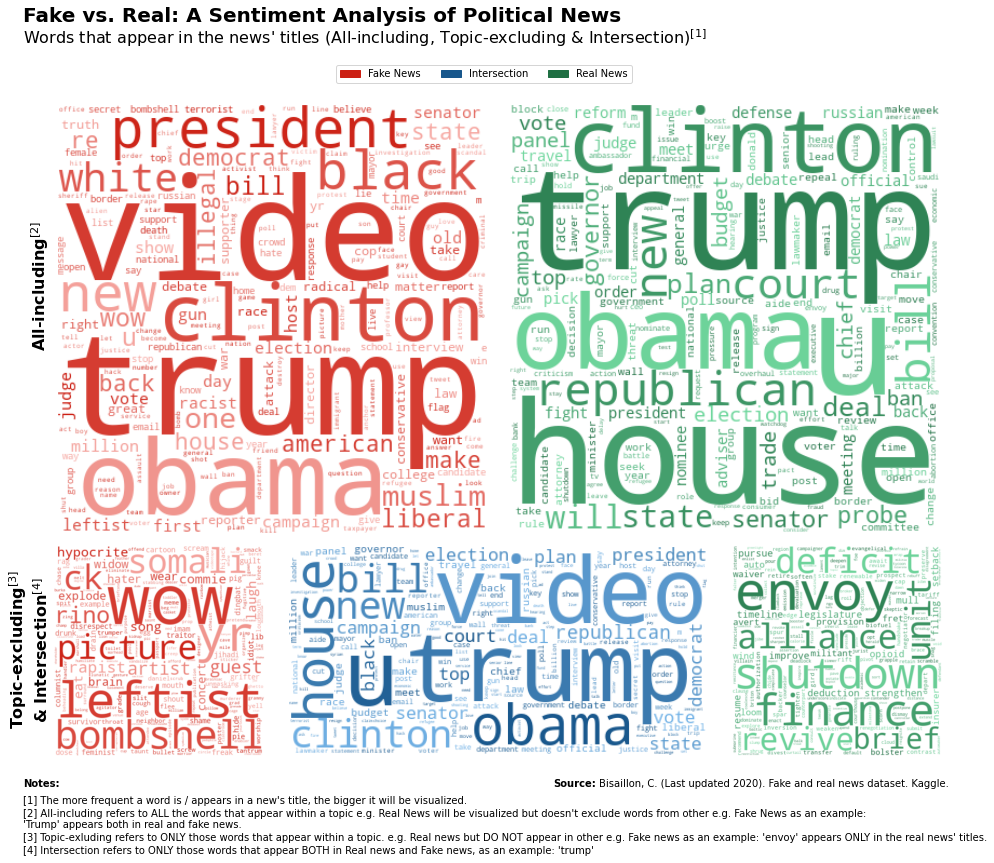

In [30]:
figure = plt.figure(figsize=(16,12))
grid = gridspec.GridSpec(3,4, figure=figure)
grid.update(wspace=0.05, hspace=0.05) # Reduce the width sapces and height spaces


# Plot the fake titles wordcloud
fake_titles_sp = plt.subplot(grid[:2, :2], frameon=False)
fake_titles_sp.imshow(fake_titles_wc, interpolation=INTERPOLATION)

# Plot the real titles wordcloud, `_sp` stands for subplot
real_titles_sp = plt.subplot(grid[:2, 2:], frameon=False)
real_titles_sp.imshow(real_titles_wc, interpolation=INTERPOLATION)

# Plot the fake titles only wordcloud
fake_titles_only_sp = plt.subplot(grid[2, 0], frameon=False)
fake_titles_only_sp.imshow(fake_titles_only_wc, interpolation=INTERPOLATION)

# Plot the intersection words between both titles
both_titles_sp = plt.subplot(grid[2, 1:3], frameon=False)
both_titles_sp.imshow(both_titles_only_wc, interpolation=INTERPOLATION)

# Plot the real titles only worcloud
real_titles_only_sp = plt.subplot(grid[2, 3:], frameon=False)
real_titles_only_sp.imshow(real_titles_only_wc, interpolation=INTERPOLATION)

# Define a list with all the subplots, Exploratory analysis Subplots
ea_subplots = [real_titles_sp, fake_titles_sp, real_titles_only_sp, both_titles_sp, fake_titles_only_sp]

# Turn off the axis
for sp in ea_subplots:
    sp.axis('off')

# Create legend elements for creating a legend with the topics/titles of the subplots
legend_elements = [
    Patch(facecolor = FAKE_COLOR_MAX, edgecolor = FAKE_COLOR_MAX, label = 'Fake News'),                 # Create a patch for the Fake news
    Patch(facecolor = BOTH_ONLY_COLOR_MAX, edgecolor = BOTH_ONLY_COLOR_MAX, label = 'Intersection'),    # Create a patch for the intersection (Words that appear in both topics)
    Patch(facecolor = REAL_COLOR_MAX, edgecolor = REAL_COLOR_MAX, label = 'Real News'),                 # Create a patch for the Real news
]
# Add a legend
figure.legend(handles=legend_elements, bbox_to_anchor=(0.5, 0.915), loc = 'center', ncol=3)

# Add text to the main figure
figure.text(0.1, 0.975, "Fake vs. Real: A Sentiment Analysis of Political News", weight = 'bold', size=TITLE_SIZE, ha='left')
figure.text(0.1, 0.950, "Words that appear in the news' titles (All-including, Topic-excluding & Intersection)$^{[1]}$", size = SUBTITLE_SIZE)
figure.text(0.105, 0.6, "All-including$^{[2]}$", size = SUBTITLE_SIZE, rotation = 90, weight = 'bold')
figure.text(0.105, 0.16, "Topic-excluding$^{[3]}$\n& Intersection$^{[4]}$", size = SUBTITLE_SIZE, rotation = 90, ha = 'center', weight='bold')

# Notes
figure.text(0.1, 0.09, "Notes:", weight = 'bold')
figure.text(0.1, 0.07, "[1] The more frequent a word is / appears in a new's title, the bigger it will be visualized.")
figure.text(0.1, 0.055, "[2] All-including refers to ALL the words that appear within a topic e.g. Real News will be visualized but doesn't exclude words from other e.g. Fake News as an example:")
figure.text(0.1, 0.0425, "'Trump' appears both in real and fake news.")
figure.text(0.1, 0.0275, "[3] Topic-exluding refers to ONLY those words that appear within a topic. e.g. Real news but DO NOT appear in other e.g. Fake news as an example: 'envoy' appears ONLY in the real news' titles.")
figure.text(0.1, 0.0125, "[4] Intersection refers to ONLY those words that appear BOTH in Real news and Fake news, as an example: 'trump'")

# Source
figure.text(0.56, 0.09, "Source:", weight = 'bold')
figure.text(0.6, 0.09, "Bisaillon, C. (Last updated 2020). Fake and real news dataset. Kaggle.")

figure.savefig('img/wordclouds_only.png', facecolor='white') # Save the figure

### **Wordcloud + Venn diagram**

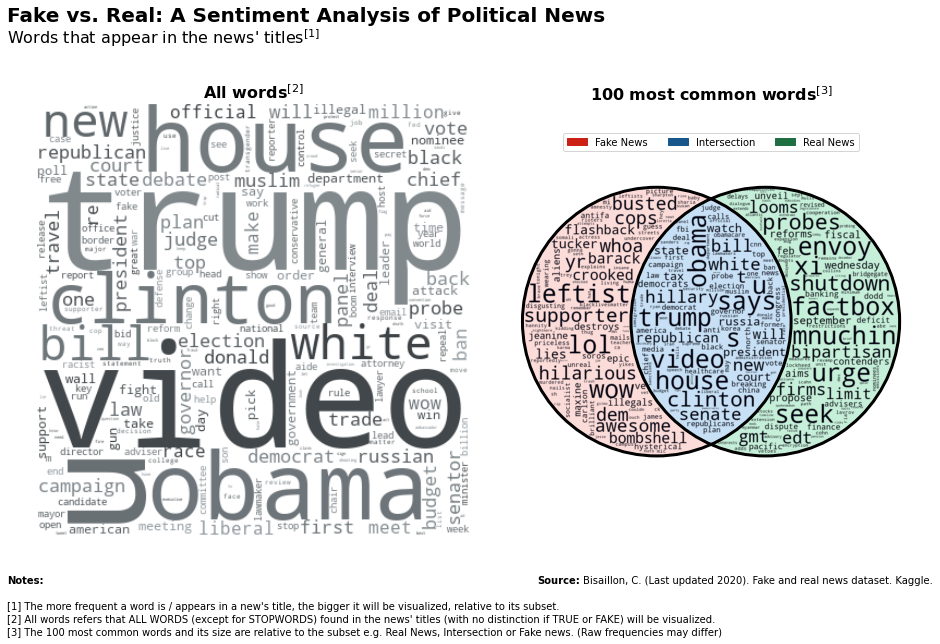

In [32]:
figure = plt.figure(figsize=FIGSIZE)
grid = gridspec.GridSpec(1, 2, figure = figure)
grid.update(wspace=0.05, hspace=0)

# First we will plot the ALL words (includes Fake and Real news) worcloud in the left
wordcloud_sp = plt.subplot(grid[0,0], frameon=False)
wordcloud_sp.imshow(both_all_titles_wc, interpolation = 'bilinear')
wordcloud_sp.axis('off') # Turn off the axis
wordcloud_sp.set_title("All words$^{[2]}$", size = SUBTITLE_SIZE, weight = 'bold')

# Plot the Venn diagram with the ´TOP´ words.
venn_sp = plt.subplot(grid[0, 1], frameon=False)
venn_sp.set_title(f"{TOP} most common words" + "$^{[3]}$", size = SUBTITLE_SIZE, weight = 'bold', y = 1.16)
venn_sp.legend(handles=legend_elements, bbox_to_anchor=(0.5, 1.05), loc = 'center', ncol=3)

# Generate a wordcloud venn diagram base on the words/tokens rank
v = venn2_wordcloud(
    [fake_titles_only_top_rank.keys() | both_titles_only_top_rank.keys(), real_titles_only_top_rank.keys() | both_titles_only_top_rank.keys()],
    word_to_frequency=titles_relative_set_rank, ax = venn_sp
)

# Add colors
v.get_patch_by_id('10').set_color(FAKE_COLOR_MIN) # REAL NEWS - LEFT SIDE
v.get_patch_by_id('11').set_color(BOTH_ONLY_COLOR_MIN) # BOTH NEWS (REAL & FAKE) - MIDDLE SIDE
v.get_patch_by_id('01').set_color(REAL_COLOR_MIN) # FAKE NEWS - RIGHT SIDE

# Add text to the main figure
figure.text(0.1, 0.850, "Fake vs. Real: A Sentiment Analysis of Political News", weight = 'bold', size=TITLE_SIZE, ha='left')
figure.text(0.1, 0.825, "Words that appear in the news' titles$^{[1]}$", size = SUBTITLE_SIZE)

# Add notes
figure.text(0.1, 0.200, "Notes:", weight = 'bold')
figure.text(0.1, 0.170, "[1] The more frequent a word is / appears in a new's title, the bigger it will be visualized, relative to its subset.")
figure.text(0.1, 0.155, "[2] All words refers that ALL WORDS (except for STOPWORDS) found in the news' titles (with no distinction if TRUE or FAKE) will be visualized.")
figure.text(0.1, 0.140, f"[3] The {TOP} most common words and its size are relative to the subset e.g. Real News, Intersection or Fake news. (Raw frequencies may differ)")

# Source
figure.text(0.56, 0.2, "Source:", weight = 'bold')
figure.text(0.6, 0.2, "Bisaillon, C. (Last updated 2020). Fake and real news dataset. Kaggle.")

# Save the figure
figure.savefig('img/wordcloud_venn.png', facecolor = 'white')

By **considering** both visualizations, it is possible to identify that if we take **a general look** in the word's that are used in both titles there are no **major differences**, instead of that the words that occur the more frequent are similar in both cases e.g. *obama*, *trump*, *clinton*. These same words are also visible in the **intersection** sets.

But, by doing a **deep-dive** in to the words that are **topic-exclusive** it is visible the difference between both. For **real news** a more **diplomatic** - **professional** like vocabulary is employed within the titles: *"envoy", "deficit", "alliance"*. For **fake news** a more **click-bait**, **eye-catching** and **unprofessional** is used e.g. *"wow", "lol", "hilarious"*.

## **Sentiment prediction with a Naive Bayes Classifier**

### **Train-test split**

As seen above, the politics news represent 40% of the total news. Also, it is visible that the current politics dataset is unbalanced, being the *real* news almost the double of *fake* ones. For simplification purposes, the dataset for the final analysis will be balanced.

We will also define a train and test set for model evaluation.

In [33]:
# 5472 records represent ~ 80% of fake news
pnews_tt = pnews.query('is_fake == 0').sample(5472, random_state=RANDOM_STATE) # real train news
pnews_ft = pnews.query('is_fake == 1').sample(5472, random_state=RANDOM_STATE) # Fake train news
pnews_train = pd.concat([pnews_tt, pnews_ft]) # Concat the train set

print(pnews_train.shape, '\n') # Print the shape of the balanced-train dataset
print(pnews_train['is_fake'].value_counts())    # Print the distribution of the `is_fake` variable

pnews_train.head()

(10944, 5) 

0    5472
1    5472
Name: is_fake, dtype: int64


,title,text,subject,date,is_fake
10365,Obama's prisoner clemency plan faltering as ca...,"WASHINGTON (Reuters) - In April 2014, the admi...",politicsNews,"March 14, 2016",0
3039,Senator Rand Paul says would consider partial ...,WASHINGTON (Reuters) - U.S. Republican Senator...,politicsNews,"June 25, 2017",0
8262,U.S. gives Laos extra $90 million to help clea...,VIENTIANE (Reuters) - The United States announ...,politicsNews,"September 6, 2016",0
2654,"Senator Corker backs Obamacare repeal with ""re...",WASHINGTON (Reuters) - Republican U.S. Senator...,politicsNews,"July 20, 2017",0
3842,Bid to revoke Obama methane rule fails in surp...,WASHINGTON (Reuters) - The U.S. Senate on Wedn...,politicsNews,"May 10, 2017",0


In [34]:
# Define a test set

# Get the fake news sample
fake_test_ix = np.setdiff1d(pnews.query('is_fake == 1').index, pnews_ft.index) # Get the indexes difference (find those that are not within the train set)
pnews_ftest = pnews.loc[fake_test_ix]


# Get the real news sample
real_test_ix = np.setdiff1d(pnews.query('is_fake == 0').index, pnews_tt.index) # Get the indexes difference (find those that are not within the train set)
pnews_ttest = pnews.loc[real_test_ix].sample(fake_test_ix.size, random_state=22)

# Concat the test samples into the test set
pnews_test = pd.concat([pnews_ftest, pnews_ttest])

print(pnews_test.shape, '\n') # Print the size of the test set
print(pnews_test['is_fake'].value_counts(), '\n') # Print the distribution of fake vs. real news

pnews_test.head()

(2738, 5) 

1    1369
0    1369
Name: is_fake, dtype: int64 



,title,text,subject,date,is_fake
30467,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,19-Feb-18,1
30471,DOJ’s JEFF SESSIONS Opens Investigation Into W...,Thank goodnesss Jeff Sessions is moving on fin...,politics,18-Feb-18,1
30474,HIGH SCHOOL TEACHER Makes “Shooting At Trump” ...,EAG News A Wyoming high school is under fire ...,politics,18-Feb-18,1
30476,BUSTED! Maxine Waters’ Ties to Black Nationali...,We reported that Maxine Waters and members of ...,politics,18-Feb-18,1
30477,LOCAL REPORTER IN DEEP BLUE STATE Stuns Libera...,"We took a very hard look at these numbers, an...",politics,17-Feb-18,1


### **1. Data Processing**

For any machine learning project, once you've gathered the data, the first step is to process it to make useful inputs to your model.
- **Remove noise / stopwords**: You will first want to remove noise from your data -- that is, remove words that don't tell you much about the content. These include all common words like 'I, you, are, is, etc...' that would not give us enough information on the sentiment.
- We'll also remove stock market tickers, retweet symbols, hyperlinks, and hashtags because they can not tell you a lot of information on the sentiment.
- You also want to remove all the punctuation from a tweet. The reason for doing this is because we want to treat words with or without the punctuation as the same word, instead of treating "happy", "happy?", "happy!", "happy," and "happy." as different words.
- Finally you want to use stemming to only keep track of one variation of each word. In other words, we'll treat "motivation", "motivated", and "motivate" similarly by grouping them within the same stem of "motiv-".

**Source**: DeepLearning.AI

Create the `process_string` function. That in easy terms, it tokenizes the words from a string i.e. conserves only words of interest (no stopwords, ASCII emojies...) and saves it into a list.

Some observations:
- Abbreviations such as **CBS** will be lost during the string process.
- ASCII emojies like `:)`, `:(` will be lost during the string process.
- A `nomenclature` argument was employed to save words like *"U.S."*.

In [70]:
def process_string(s, nomenclature = True):
    """
    Process a string by eliminating stopwords, tokenizing and stemming the words.

    # Arguments
    s: str
        A string to be processed.
    nomenclature: boolean
        Indicates if want to include nomenclature in tokens. i.e. U.S.
        
    # Return
    clean_tokens: list
        A list with clean tokens.
    """

    clean_tokens = [] # Set an empty list for cleaned tokens

    # Validate if we want to validate first the existence of nomenclature
    if nomenclature:
        nom_regex = '(?:[A-Z]\.){1,}'               # A regex for identifying nomenclature like 'U.S.'
        nom_regex_find = re.findall(nom_regex, s)   # Find all the occurences for the nomeclature regex
        if len(nom_regex_find) > 0:                 # Validate that there is at least one result within the find
            clean_tokens += nom_regex_find          # Append the found nomenclatures into the clean_tokens list
            s = re.sub(nom_regex, '', s)            # Replace the found nomeclanture with empty spaces, wont be considered for tokenizing

    non_word_regex = '[^\w]'                                # Create a regex for identifying non-words, e.g. '!', '’', '.' ...
    s_words_only = re.sub(non_word_regex, ' ', s.lower())   # Replace non-word symbols with an empty space

    stemmer = PorterStemmer()                       # Init a Porter stemmer, gets the root/stem of the words
    en_stopwords = stopwords.words('english')       # Store the english stopwords, they are not as relevant in a sentiment 
    tokens = word_tokenize(s_words_only)            # Create a list with tokens, using the nltk.word_tokenize

    # Create a list of clean tokens by stemming each word
    # if the word is not within the unwanted words. (e.g. stopwords/punctuation)
    clean_tokens += [
        stemmer.stem(word) for word in tokens
        if word not in en_stopwords
        if not re.match(non_word_regex, word)
    ]

    return clean_tokens

EXAMPLE_STR = "This is an example string. :)"
print(f"{Fore.GREEN}{Style.BRIGHT}Example:{Style.RESET_ALL} {EXAMPLE_STR} -> {process_string(EXAMPLE_STR)}")

Example: This is an example string. :) -> ['exampl', 'string']


Create the `build_freqs` function. What this function does is taking a string, tokenizes the words and pairs each one of the words, with the current string's sentiment. e.g. `(word_1, sentiment_1)`. This process iterates over each of the available strings and while so, it is evaluated if a given pair e.g. `(word_1, sentiment_1)` it's already in the `freqs` dictionary and if it does, adds 1 to its current value, else, opens a new key with value 1. This last works as a frequency counter.

In [36]:
def build_freqs(strings, sentiments, counter = True):
    """
    Build frequencies of tokens/words given its sentiment.
    
    strings: list
        A list of strings/sentences.
    sentiments: list
        A list with the sentiment of the strings/sentences.
    counter: boolean (default = True)
        A boolean that indicates whether or not to return the freqs as a `Counter` object
    """

    # Start with an empty dictionary and populate it with the the pairs of combinations (word, sentiment).
    freqs = {}

    # Iterate over each string and its sentiment
    for s, sentiment in zip(strings, sentiments):
        clean_tokens = process_string(s) # Process the string and get its clean tokens
        for word in clean_tokens:
            pair = (word, sentiment)    # Create a a tuple with the `item` and its `sentiment`
            if pair in freqs.keys():    # Identify whether or not the pair is within the keys
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    if counter: freqs = Counter(freqs)

    return freqs

In [37]:
# Get the freqs from the political news dataset
freqs = build_freqs(pnews_train.title, pnews_train.is_fake)

# Print an example of what the `freqs` variable looks like
print(freqs.most_common(HEAD))

[(('video', 1), 2732), (('trump', 0), 2456), (('trump', 1), 1895), (('U.S.', 0), 1495), (('hillari', 1), 840)]


## **2 - Train your Model using Naive Bayes**


Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

#### So how do you train a Naive Bayes classifier?
- The first part of training a naive bayes classifier is to identify the number of classes that you have.
- You will create a probability for each class.
$P(D_{pos})$ is the probability that the document is positive.
$P(D_{neg})$ is the probability that the document is negative.
Use the formulas as follows and store the values in a dictionary:

$$P(D_{pos}) = \frac{D_{pos}}{D}\tag{1}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}\tag{2}$$

Where $D$ is the total number of documents, or tweets in this case, $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.

**Source**: DeepLearning.AI

For this project, the **positive** sentimient will be equivalent to the **real** news and viceversa, and the **negative** to the **fake** news. 

#### **Prior and Logprior**

The prior probability represents the underlying probability in the target population that a tweet is positive versus negative.  In other words, if we had no specific information and blindly picked a tweet out of the population set, what is the probability that it will be positive versus that it will be negative? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{pos})}{P(D_{neg})}$.
We can take the log of the prior to rescale it, and we'll call this the logprior

$\text{logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$.

Note that $log(\frac{A}{B})$ is the same as $log(A) - log(B)$.  So the logprior can also be calculated as the difference between two logs:

$$\text{logprior} = \log (P(D_{pos})) - \log (P(D_{neg})) = \log (D_{pos}) - \log (D_{neg})\tag{3}$$


### **Exercise 2 - train_naive_bayes**
Given a freqs dictionary, `train_x` (a list of tweets) and a `train_y` (a list of labels for each tweet), implement a naive bayes classifier.

##### Calculate $V$
- You can then compute the number of unique words that appear in the `freqs` dictionary to get your $V$ (you can use the `set` function).

##### Calculate $freq_{pos}$ and $freq_{neg}$
- Using your `freqs` dictionary, you can compute the positive and negative frequency of each word $freq_{pos}$ and $freq_{neg}$.

##### Calculate $N_{pos}$, and $N_{neg}$
- Using `freqs` dictionary, you can also compute the total number of positive words and total number of negative words $N_{pos}$ and $N_{neg}$.

##### Calculate $D$, $D_{pos}$, $D_{neg}$
- Using the `train_y` input list of labels, calculate the number of documents (tweets) $D$, as well as the number of positive documents (tweets) $D_{pos}$ and number of negative documents (tweets) $D_{neg}$.
- Calculate the probability that a document (tweet) is positive $P(D_{pos})$, and the probability that a document (tweet) is negative $P(D_{neg})$

##### Calculate the logprior
- the logprior is $log(D_{pos}) - log(D_{neg})$

##### Calculate log likelihood
- Finally, you can iterate over each word in the vocabulary, use your `lookup` function to get the positive frequencies, $freq_{pos}$, and the negative frequencies, $freq_{neg}$, for that specific word.
- Compute the positive probability of each word $P(W_{pos})$, negative probability of each word $P(W_{neg})$ using equations 4 & 5.

$$ P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}\tag{4} $$
$$ P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}\tag{5} $$

**Note:** We'll use a dictionary to store the log likelihoods for each word.  The key is the word, the value is the log likelihood of that word).

- You can then compute the loglikelihood: $log \left( \frac{P(W_{pos})}{P(W_{neg})} \right)$.

In [39]:
def train_naive_bayes(train_x, train_y, freqs):
    """Train a binary - Naive Bayes Classifier for text

    # Arguments
    train_x: array-like
        An array with strings a.k.a Documents.
    train_y: array-like
        An array with the the sentiment labels.
    freqs: dictionary-like
        A dictionary with (word, sentiment) frequencies

    # Return
    logprior: float
        The logprior value i.e. the log ratio between positive and negative Documents.
    loglikelihood: dict
        A dictionary with the loglikelihood (the log ratio between positive and negative frequencies for a word) of words.
    """
    loglikelihood = {}  # A dictionary for saving each word's loglikelihood  
    logprior = 0        # A default init, replaced later (if not a BALANCED SET) i.e. same amount of positive and negative Documents

    # -----
    # Calculate V
    #
    # We only want the set of the words within the freqs, dictionary.
    # Understanding that the keys within `freqs` are of the type: (word, sentiment)
    # we only need to extract the first object of the item. `item[0]` = word
    # -----
    vocab = set([item[0] for item in freqs.keys()])
    V = len(vocab) # Get only the length of the vocabulary

    # -----
    # Calculate `N_pos` and `N_neg` i.e. the number of ALL positive and negative words within `freqs`.
    #
    # Via list comprehension, we will get the frequency of those pairs which first element item[1]
    # is equal to the sentiment we want to count. e.g. sentiment == 1. 
    # -----

    N_pos = np.array([freq for pair, freq in freqs.items() if pair[1] == 1]).sum()
    N_neg = np.array([freq for pair, freq in freqs.items() if pair[1] == 0]).sum()

    # Calculate `D_pos` and `D_neg` i.e. the number of positive and negative Documents (the entire string)
    D_pos = np.sum(train_y == 1)
    D_neg = np.sum(train_y == 0)

    # Calculate the log prior
    logprior = np.log(D_pos) - np.log(D_neg)

    # -----
    # Calculate `freq_pos` and `freq_neg` for each one of the words. Their probability and, finally, the loglikelihood.
    # i.e. the ratio-probability positive-negative.
    # -----
    for word in vocab:

        # Get the frequencies of the word for each one of the sentiments/labels
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)

        # Get the probability of the word for each one of the sentiments/labels
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
    
        # Compute the loglikelihood,
        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg) # Equivalent to `np.log(p_w_pos/p_w_neg)`
        
    return logprior, loglikelihood

In [40]:
# Get the `logprior` and `loglikelihood` of the training set.
logprior, loglikelihood = train_naive_bayes(pnews_train.title, pnews_train.is_fake, freqs)

# Print the results
print(f"{Fore.GREEN}{Style.BRIGHT}Logprior:{Style.RESET_ALL} {logprior}")
print(f"{Fore.GREEN}{Style.BRIGHT}Loglikelihood's lenght:{Style.RESET_ALL} {len(loglikelihood):,.0f}")
print(f"{Fore.GREEN}{Style.BRIGHT}Vocabulary length:{Style.RESET_ALL} {len(set([item[0] for item in freqs.keys()])):,.0f}")

Logprior: 0.0
Loglikelihood's lenght: 8,350
Vocabulary length: 8,350


Now, crate a function that predicts the **sentiment** of a given string i.e. title, based on our **trained naive bayes classifier**

In [58]:
def naive_bayes_predict(string, logprior, loglikelihood, tokenizer = process_string, return_p = False):
    """
    Predict a string category/sentiment given itself, the logprior and a loglikelihood.

    # Arguments
    string: `str`
        String to be predicted.
    logprior: `float`
        The logprior i.e. the probability ratio of positive vs. negative Documents.
    loglikelihood: `dict`
        A dictionary with word as key and lodlikelihood as value. The loglikelihood is the probability ratio of positive vs. negative.
    tokenizer: `function` (default `process_string`)
        A function that process a string and return a list with tokens.
    return_p: `boolean` (default: `False`)
        Boolean that indicates if return probability instead of the category itself.

    # Return
    p: `float`
        the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
    """
    p = 0           # Init the probability with zero
    p += logprior   # Add the logprior

    # Tokenize the string and return a list of tokens
    tokens = tokenizer(string)

    # Evaluate each of the tokens and look for them in the `loglikelihood` dictionary.
    # If found, add the loglikelihood value in to the current probability.
    for token in tokens:
        if token in loglikelihood:
            p += loglikelihood[token]

    if return_p: return p

    # Get the actual class/sentiment given the probability `p`
    pred = 1 if p > 0 else 0

    return pred

In [57]:
FAKE_EXAMPLE = pnews_train.sample(1, random_state=RANDOM_STATE).iloc[0]
print(f"{Fore.GREEN}{Style.BRIGHT}Title:{Style.RESET_ALL} {FAKE_EXAMPLE.title}")
print(f"{Fore.GREEN}{Style.BRIGHT}Title's real sentiment/category:{Style.RESET_ALL} {FAKE_EXAMPLE.is_fake}")
print(f"{Fore.GREEN}{Style.BRIGHT}Title's pred sentiment/category:{Style.RESET_ALL} {naive_bayes_predict(FAKE_EXAMPLE.title, logprior, loglikelihood)}")

Title: TRUMP WARNED AMERICANS We’d Be “Sick Of Winning”…CNN Cries Trump Is Making Stock Market Rise Too Much…Could Hurt His Chances For Re-election [VIDEO]
Title's real sentiment/category: 1
Title's pred sentiment/category: 1


Now generate a function that compute the **accuracy** of the model. 

In [67]:
def accuracy_naive_bayes(X, Y, logprior, loglikelihood, naive_bayes_predict = naive_bayes_predict):
    """
    Given a x and y set, and probability measures such as logprior and loglikelihood, the accuracy will be computed.
    
    # Arguments
    X: `np.array`-like `pandas.Series` also acccepted
        A set of strings.
    Y: `np.array`-like `pandas.Series` also acccepted
        A set of labels (sentiments/classifications).
    logprior: `float`
        The logprior i.e. the probability ratio of positive vs. negative Documents.
    loglikelihood: `dict`
        A dictionary with word as key and lodlikelihood as value. The loglikelihood is the probability ratio of positive vs. negative.7
    naive_bayes_predict: `function`
        Function that predicts label (sentiment/category).

    # Return
    accuracy: `float`
        The accuracy of prediction vs. real labels.
    """
    # Evaluate if the length between X and Y sets, are the same.
    if len(X) != len(Y):
        print(f"X - size {len(X)} is different from Y - size {len(Y)}. Can't proceed.")
        return None

    N_accurate = 0 # Init the number of accurate predictions with zero
    N_total = len(X)

    # For each one of the strings and real labels, evaluate
    # whether the prediction was accurate or not and add the result
    # into the `accuracy` metric.
    for string, label in zip(X, Y):
        pred = naive_bayes_predict(string, logprior, loglikelihood) # Compute the prediction
        if label == pred:
            N_accurate += 1

    # Compute the accuracy
    accuracy = N_accurate / N_total

    return accuracy    

Now **compute the accuracy** of the train and test sets.

In [69]:
print(f"{printf_title('Train set - accuracy')}{accuracy_naive_bayes(pnews_train.title, pnews_train.is_fake, logprior, loglikelihood):.1%}")
print(f"{printf_title('Test set - accuracy')}{accuracy_naive_bayes(pnews_test.title, pnews_test.is_fake, logprior, loglikelihood):.1%}")

Train set - accuracy: 96.2%
Test set - accuracy: 94.0%


As an **extra**,] merge **all the used functions for classifying** and create a **class** with them.

In [100]:
class NLP_NaiveBayesClassifier():
    """
    A Naive Bayes Classifier for Natural Language Processing.

    # Arguments
    tokenizer: `function` (default `process_string`)
            A function that process a string and return a list with tokens.
    """
    def __init__(self, tokenizer):
        """
        # Arguments
        self.tokenizer: `function`
            A function that process a string and return a list with tokens.
        self.logprior: `float`
            The logprior value i.e. the log ratio between positive and negative Documents.
        self.loglikelihood: `dict`
            A dictionary with the loglikelihood (the log ratio between positive and negative frequencies for a word) of words.
        self.freqs: `dict`ionary-like
            A dictionary with (word, sentiment/label) frequencies.
        self.fit_x: `array`-like
            An array with strings a.k.a Documents.
        self.fit_y: `array`-like
            An array with the the sentiment labels.
        self.N_documents: `int`
            The number of documents i.e. sentences/strings in the train/fit set.
        self.N_vocab: `int`
            The number of unique words found within the documents.
        """
        self.tokenizer = tokenizer  # The tokenizer to be used to get clean_tokens. Used in `build_freqs`, `predict()`
        self.logprior = 0           # Updated in the `self.fit()` function. Used in `predict()`
        self.loglikelihood = 0      # Updated in the `self.fit()` function. Used in `predict()`
        self.freqs = 0              # Updated in the `self.fit()` function.
        self.fit_x = 0              # Updated in the `self.fit()` function. Used in `accuracy()` if None.
        self.fit_y = 0              # Updated in the `self.fit()` function. Used in `accuracy()` if None.
        self.N_documents = 0        # Updated in the `self.fit()` function.
        self.N_vocab = 0            # Updated in the `self.fit()` function.


    def build_freqs(self, strings, labels, counter = True):
        """
        Build frequencies of tokens/words given its labels/sentiments.
        
        strings: list
            A list of strings/sentences.
        labels: list
            A list with the sentiment of the strings/sentences.
        counter: boolean (default = True)
            A boolean that indicates whether or not to return the freqs as a `Counter` object
        """

        # Start with an empty dictionary and populate it with the the pairs of combinations (word, sentiment).
        freqs = {}

        # Iterate over each string and its sentiment
        for string, label in zip(strings, labels):
            clean_tokens = self.tokenizer(string) # Process the string and get its clean tokens
            for word in clean_tokens:
                pair = (word, label)    # Create a a tuple with the `item` and its `sentiment`
                if pair in freqs.keys():    # Identify whether or not the pair is within the keys
                    freqs[pair] += 1
                else:
                    freqs[pair] = 1

        if counter: freqs = Counter(freqs)

        return freqs


    def fit(self, train_x, train_y):
        """Train a binary - Naive Bayes Classifier for text

        # Arguments
        train_x: array-like
            An array with strings a.k.a Documents.
        train_y: array-like
            An array with the the sentiment labels.
        freqs: dictionary-like
            A dictionary with (word, sentiment) frequencies

        # Return
        logprior: float
            The logprior value i.e. the log ratio between positive and negative Documents.
        loglikelihood: dict
            A dictionary with the loglikelihood (the log ratio between positive and negative frequencies for a word) of words.
        """
        # Compute the freqs dictionary
        self.freqs = self.build_freqs(train_x, train_y)
        self.fit_x = train_x
        self.N_documents = len(self.fit_x)
        self.fit_y = train_y

        loglikelihood = {}  # A dictionary for saving each word's loglikelihood  
        logprior = 0        # A default init, replaced later (if not a BALANCED SET) i.e. same amount of positive and negative Documents

        # -----
        # Calculate V
        #
        # We only want the set of the words within the freqs, dictionary.
        # Understanding that the keys within `freqs` are of the type: (word, sentiment)
        # we only need to extract the first object of the item. `item[0]` = word
        # -----
        vocab = set([item[0] for item in self.freqs.keys()])
        V = len(vocab) # Get only the length of the vocabulary
        self.N_vocab = V

        # -----
        # Calculate `N_pos` and `N_neg` i.e. the number of ALL positive and negative words within `freqs`.
        #
        # Via list comprehension, we will get the frequency of those pairs which first element item[1]
        # is equal to the sentiment we want to count. e.g. sentiment == 1. 
        # -----

        N_pos = np.array([freq for pair, freq in self.freqs.items() if pair[1] == 1]).sum()
        N_neg = np.array([freq for pair, freq in self.freqs.items() if pair[1] == 0]).sum()

        # Calculate `D_pos` and `D_neg` i.e. the number of positive and negative Documents (the entire string)
        D_pos = np.sum(train_y == 1)
        D_neg = np.sum(train_y == 0)

        # Calculate the log prior
        logprior = np.log(D_pos) - np.log(D_neg)

        # -----
        # Calculate `freq_pos` and `freq_neg` for each one of the words. Their probability and, finally, the loglikelihood.
        # i.e. the ratio-probability positive-negative.
        # -----
        for word in vocab:

            # Get the frequencies of the word for each one of the sentiments/labels
            freq_pos = self.freqs.get((word, 1), 0)
            freq_neg = self.freqs.get((word, 0), 0)

            # Get the probability of the word for each one of the sentiments/labels
            p_w_pos = (freq_pos + 1) / (N_pos + V)
            p_w_neg = (freq_neg + 1) / (N_neg + V)
        
            # Compute the loglikelihood,
            loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg) # Equivalent to `np.log(p_w_pos/p_w_neg)`

        self.logprior = logprior
        self.loglikelihood = loglikelihood   
        # return logprior, loglikelihood


    def predict(self, string, return_p = False):
        """
        Predict a string category/sentiment given itself, the logprior and a loglikelihood.

        # Arguments
        string: `str`
            String to be predicted.
        logprior: `float`
            The logprior i.e. the probability ratio of positive vs. negative Documents.
        loglikelihood: `dict`
            A dictionary with word as key and lodlikelihood as value. The loglikelihood is the probability ratio of positive vs. negative.
        tokenizer: `function` (default `process_string`)
            A function that process a string and return a list with tokens.
        return_p: `boolean` (default: `False`)
            Boolean that indicates if return probability instead of the category itself.

        # Return
        p: `float`
            the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
        """
        p = 0           # Init the probability with zero
        p += self.logprior   # Add the logprior

        # Tokenize the string and return a list of tokens
        tokens = self.tokenizer(string)

        # Evaluate each of the tokens and look for them in the `loglikelihood` dictionary.
        # If found, add the loglikelihood value in to the current probability.
        for token in tokens:
            if token in self.loglikelihood:
                p += self.loglikelihood[token]

        if return_p: return p

        # Get the actual class/sentiment given the probability `p`
        pred = 1 if p > 0 else 0

        return pred
    
    
    def accuracy(self, X = None, Y = None):
        """
        Given a x and y set, and probability measures such as logprior and loglikelihood, the accuracy will be computed.
        
        # Arguments
        X: `np.array`-like `pandas.Series` also acccepted
            A set of strings.
        Y: `np.array`-like `pandas.Series` also acccepted
            A set of labels (sentiments/classifications).
        logprior: `float`
            The logprior i.e. the probability ratio of positive vs. negative Documents.
        loglikelihood: `dict`
            A dictionary with word as key and lodlikelihood as value. The loglikelihood is the probability ratio of positive vs. negative.7
        naive_bayes_predict: `function`
            Function that predicts label (sentiment/category).

        # Return
        accuracy: `float`
            The accuracy of prediction vs. real labels.
        """
        if X is None or Y is None:
            X = self.fit_x
            Y = self.fit_y

        # Evaluate if the length between X and Y sets, are the same.
        if len(X) != len(Y):
            print(f"X - size {len(X)} is different from Y - size {len(Y)}. Can't proceed.")
            return None

        N_accurate = 0 # Init the number of accurate predictions with zero
        N_total = len(X)

        # For each one of the strings and real labels, evaluate
        # whether the prediction was accurate or not and add the result
        # into the `accuracy` metric.
        for string, label in zip(X, Y):
            pred = self.predict(string) # Compute the prediction
            if label == pred:
                N_accurate += 1

        # Compute the accuracy
        accuracy = N_accurate / N_total

        return accuracy

Replicate the **training** and **prediction** of the **separate functions** with the use of the `NLP_NaiveBayesClassifier` class.

In [113]:
# Print the section header
print(f"{printf_title(PREDICTION_HEADER, Fore.RED)}\n")

# Init the class
nlp_nbc = NLP_NaiveBayesClassifier(tokenizer = process_string)  # Define the tokenizer for getting clean tokens/words
nlp_nbc.fit(pnews_train.title, pnews_train.is_fake)             # Fit/train the model

# Print informational metrics from the fit model
print(f"{printf_title('> Number of documents in fit model')}{nlp_nbc.N_documents:,.0f}")
print(f"{printf_title('> Number of unique words found in fit model')}{nlp_nbc.N_vocab:,.0f}")
print(f"{printf_title('> Train/Fit set - accuracy')}{nlp_nbc.accuracy():.1%}")
print(f"{printf_title('> Test set - accuracy')}{nlp_nbc.accuracy(pnews_test.title, pnews_test.is_fake):.1%}")



 / \--------------------------------------, 
 \_,|    Fake vs. Real:                   | 
    |    A Prediction of Political News   |
    |                                     |
    |    @system-rowb                     |
    |  ,------------------------------------
    \_/___________________________________/ 
: 

> Number of documents in fit model: 10,944
> Number of unique words found in fit model: 8,350
> Train/Fit set - accuracy: 96.2%
> Test set - accuracy: 94.0%


## **Conclusion**

For the **exploratory analysis** made up with **wordclouds** and **venn-diagrams** it was able to identify a **difference of vocabulary** used in **fake** vs. **real** news. Particularly, **fake news** seemed to use a more **click-bait, eye-catching and unprofessional** vocabulary while **real news** employed a more **diplomatic and professional** one.

According to the **label/sentiment classification**, **amazing accuracy** so far was achieved, both for the **training** (96.2%) and **test** (94.0%) set. Still, some extra evaluation (e.g. **more metrics**) should be done to the model or the data itself to prevent from possible **biases** or **errors** during the **recolection**, **processing** or **classification** steps.

Similarly, other **approaches** should be considered like **taking into account** the **abbreviations** like *"U.S." or "CNN"*, or also considering the **length** of titles, number of **punctuation** or even **capital letters**.

This **approach** only considered the **political news** with **focus on titles**, but it is highly recommended to include the **news' content** as well, or a set with **more variety in topics**.